# Neural Network Binary:
A basic implementation of the sampled binary Neural Network which includes:
- Encoding categorical features with the encoder classes.
- Viewing the distribution of majority labels using a visualiser.
- Preprocessing data for a Neural Network.
- Optimising the Neural Network and saving it to a folder.
- Loading a saved Neural Network from the given path.
- Evaluating Training and Test set results.
- Integrating the results into shap using the shap manager class.

In [1]:
# Check the working directory and set it to the main folder if needed.
# Set the directory to the main directory for imports.
import os
os.getcwd()

'c:\\Users\\adi_s\\Desktop\\LSTM\\UserGuides'

In [2]:
# Changing to main directory for Module imports.
os.chdir('../')

Imports and Dependencies. Most modules will be loaded as they are needed for explainability.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

We load a given dataset that should be placed in the Data folder in UserGuide. For this we will use the current data. This is a binary classification example so the dataset used should be binary.

In [4]:
# Preprocess.
data = pd.read_csv('UserGuides/Data/Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# A little bit of extra cleaning.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_27468\62178567.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('UserGuides/Data/Cleaned_full_data.csv')


For the purpose of simplifying the the example we use a smaller sample.

In [5]:
data = data.sample(n=10000)
# Need to reset the index otherwise we can get Nulls.
data = data.reset_index(drop=True)

Now we find our categorical features. Here we want to make sure we don't include any features that are actually labels. In this case its 'attack_cat'.
Keep in mind that at times they may be of type 'category' instead where we would use 'category' instead of 'object' as a dtype.

In [6]:
categories = data.select_dtypes(include='object').columns.tolist()
print(categories)
# We remove attack_cat from the list:
if 'attack_cat' in categories:
    categories.remove('attack_cat')
print(categories)

['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service', 'attack_cat']
['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service']


Because the Neural Network requires categories to be one-hot encoded we use the correlation one-hot encoder to get the most relevant features based on certain thresholds. Since we have a binary classification label this becomes particularly useful. The procedure goes through each value inside a categorical feature and converts it to a binary. Then it calculates the correlation for two binaries (Phi coefficient) between it and the label which in this case is the threat label. The encoder also helps to deal with memory allocation issues. If we were to to one-hot encode all the values, we will get an error as we would have an array of more than approximately 5,750,000,000 values. It also spares us the effort drawing the correlation seperately and inputing it into the OneHotEncoder class as it is all automatic.

In [7]:
# Import the correlation encoder.
from Tools.encoders import CorrOnehotEncoder
# Print the docstring.
help(CorrOnehotEncoder)

Help on class CorrOnehotEncoder in module Tools.encoders:

class CorrOnehotEncoder(builtins.object)
 |  CorrOnehotEncoder(column, target)
 |
 |  CorrOnehotEncoder: Encodes the given column by creating one-hot encoded columns for categories that have
 |  a correlation higher than a threshold with the target column.
 |
 |  Methods defined here:
 |
 |  __init__(self, column, target)
 |      Parameters:
 |          - column (pd.Series) The feature column to encode.
 |          - target (pd.Series) The target column.
 |
 |  corr(self, x, y)
 |      Calculate the Pearson correlation coefficient (Phi).
 |
 |      Parameters:
 |          - x (tensor - float32) The first variable.
 |          - y (tensor - float32) The target to draw correlation to.
 |
 |      Returns:
 |          - r (float32) The Pearson correlation coefficient (Phi).
 |
 |  encode(self, sparse_n, threshold, max_encoded)
 |      Encode the feature column by creating one-hot encoded columns for categories that have
 |      a c

In [8]:
# Parameters:
# The minimum number of 1's in the value (deals with sparse data). Since we are using sample data of 10, 000 we keep this pretty low.
sparse_n = 200
# The threshold for correlation. 0 means the binary must have atleast some correlation. Correlation is collected for positive and negative instances.
threshold = 0.1
# The limit for the encoded features. After collecting correlation the highest correlated values are sorted (highest to lowest) and the maximum is selected.
max_encoded = 30
ce = CorrOnehotEncoder(data['srcip'], data['label'])
ohe1 = ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['sport'], data['label'])
ohe2= ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['dstip'], data['label'])
ohe3 = ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['dsport'], data['label'])
ohe4 = ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['proto'], data['label'])
ohe5 = ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['state'], data['label'])
ohe6 = ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['service'], data['label'])
ohe7 = ce.encode(sparse_n, threshold, max_encoded)

Before adding the data back in lets take a quick look at what the data looks like for Normal labels (the majority label). We can evaluate how noisy the data is in the label based on different scalers. The cluster visualiser is limited to looking at continous data so will need to filter out binaries and discreet variables with small amounts of unique values.

In [9]:
# Create a new dataset with just Normal labels and make sure to drop the categorical columns from before.
cluster_data = data.drop(columns=categories)
# Now we set it to just Normal labels.
cluster_data = cluster_data[cluster_data['attack_cat'] == 'Normal']

In [10]:
# Now we try and filter for mostly continuous variables.
# Collect variables.
remove = []
for i in cluster_data:
    if len(cluster_data[i].unique()) < 30:
        remove.append(i)
# Drop the varibles collected.
cluster_data = cluster_data.drop(columns=remove)

In [11]:
# Import the cluster visualiser and read doc.
from Tools.cluster_visualiser import PlotClusters
# Read the docs.
help(PlotClusters)

Help on class PlotClusters in module Tools.cluster_visualiser:

class PlotClusters(builtins.object)
 |  PlotClusters(data, scaler_type, sample_size)
 |
 |  PlotClusters: A class that plots different clusters in a 3-D plot with augmentations. Easily evaluate K-means++ clusters or use DBSCAN to seperate noise from other clusters.
 |  Use either just the normal Kmeans++ to 3D or DBSCAN to 3D or optionally project it through TSNE. Makes it easy to quickly visualise within label groups.
 |
 |  Methods defined here:
 |
 |  __init__(self, data, scaler_type, sample_size)
 |      Parameters:
 |          - data (pd.DataFrame) The Dataset to analyse which should have the labels filtered out.
 |          - scaler_type (string) Either use 'standard' or 'minmax' scaler.
 |          - sample_size (int) Sample a smaller size - increasing this to above 10000 significantly increasing computation for TSNE.
 |
 |  plot_dbscan(self, eps=0.5, min_samples=20)
 |      plot_tsne:  DBSCAN clustering and visuali

We will use TSNE so we do not have to reduce our data using PCA. This will allow us to visualise more points. The problem with 2D planes and PCA is that we lose explainability based on the cumulative percentage of PCA components. TSNE does a much better job at capturing the data. We combine this with DBScan which helps us to plot the noise in the data as red dots. Lets check what the data looks like when we use Standard Scaling and Min Max Scaling.

Standard Scaler

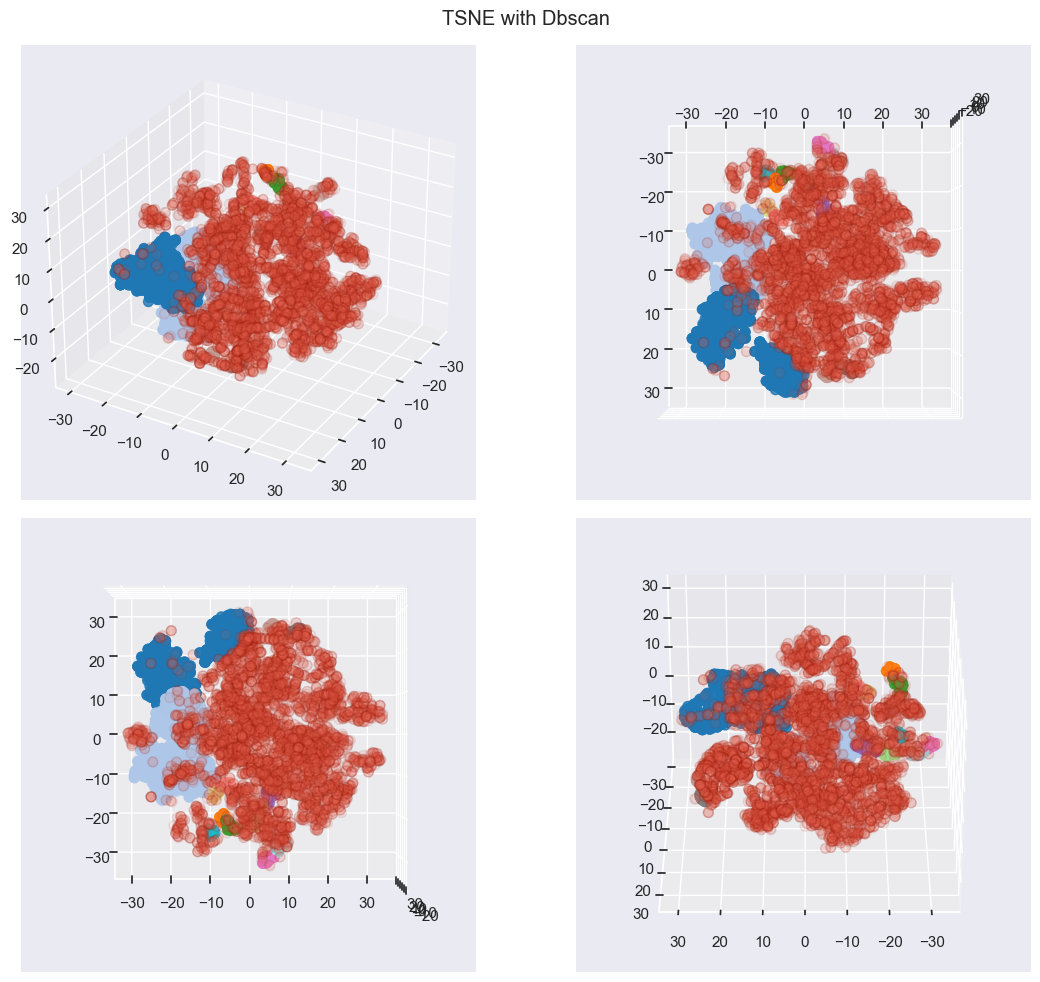

In [12]:
# Check Standard scaling data.
scaler = 'standard'
# Select the same size as all the currently sampled data. A limit of 10000 is recommended as TSNE is computationally expensive.
sample_size = 10000
pc = PlotClusters(cluster_data, scaler, sample_size)
# Ommit PCA conversion.
apply_pca = False
# DBSCAN doesnt use clusters.
n_clusters = None
# Learning rate for TSNE - this sometimes impacts the shape we get in the plots. We will set it to automatic.
learning_rate = 'auto'
# The perplexity directly affects the shape output of TSNE. Can at sometimes be pretty random but 30 usually works quite well. As we increase it towards 100 we get more stringy
# type results.
perplexity=30
# Select DBScan type clusters.
cluster_type = 'dbscan'
# Epsilon is the threshold for noise. It decides the ring (epsilon) at which to classify the points as noise or not.
epsilon = 0.5
pc.plot_tsne(apply_pca, n_clusters, learning_rate, perplexity, cluster_type, epsilon)

Now Lets Check Min-Max Scaling.

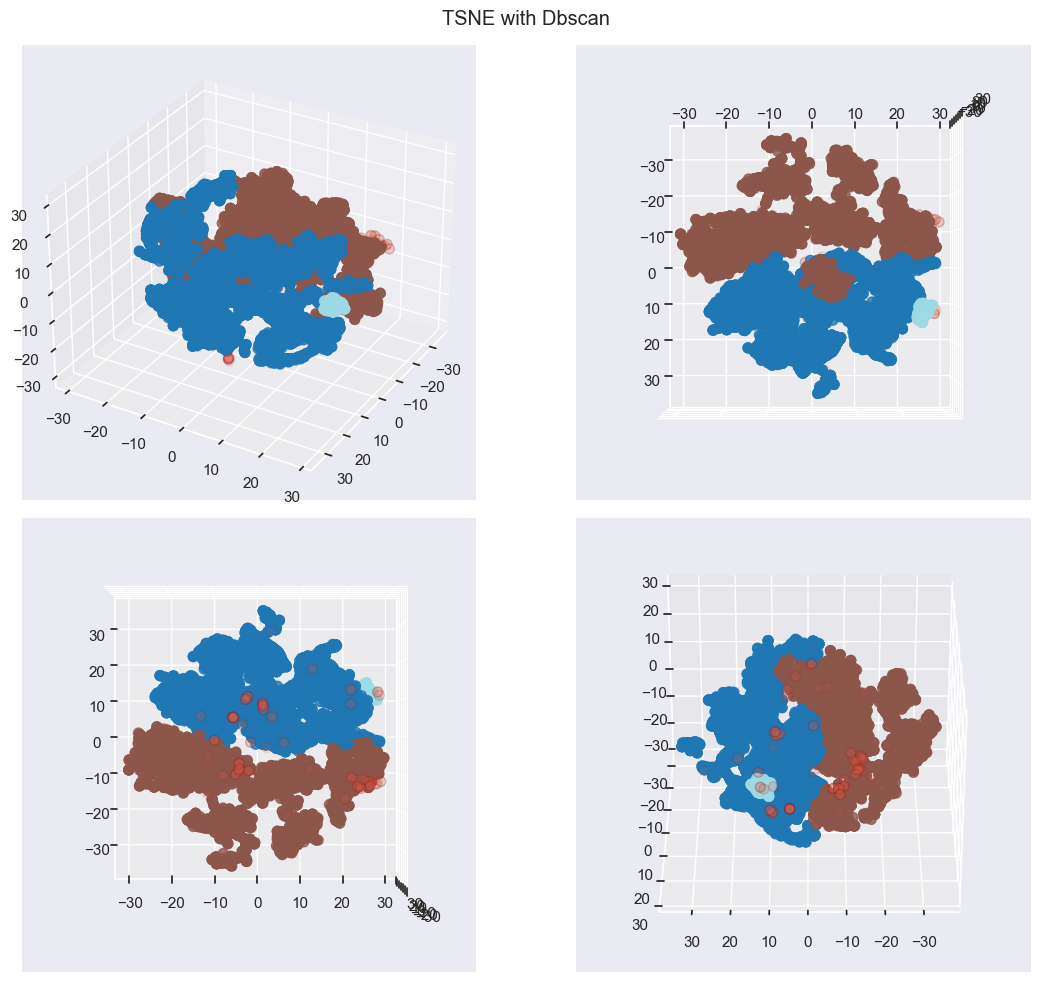

In [13]:
# Check Min-Max scaling data.
scaler = 'minmax'
# Select the same size as all the currently sampled data. A limit of 10000 is recommended as TSNE is computationally expensive.
sample_size = 10000
pc = PlotClusters(cluster_data, scaler, sample_size)
# Ommit PCA conversion.
apply_pca = False
# DBSCAN doesnt use clusters.
n_clusters = None
# Learning rate for TSNE - this sometimes impacts the shape we get in the plots. We will set it to automatic.
learning_rate = 'auto'
# The perplexity directly affects the shape output of TSNE. Can at sometimes be pretty random but 30 usually works quite well. As we increase it towards 100 we get more stringy
# type results.
perplexity=30
# Select DBScan type clusters.
cluster_type = 'dbscan'
# Epsilon is the threshold for noise. It decides the ring (epsilon) at which to classify the points as noise or not.
epsilon = 0.5
pc.plot_tsne(apply_pca, n_clusters, learning_rate, perplexity, cluster_type, epsilon)

Ok so we see that noise is presumably reduced in Normal labels when using min-max scaling based on the same epsilon and will go forward as using that as our scaler in the Neural Network. Now lets continue pre-processing the data by scaling it and recombining the encoded features.

In [14]:
# Drop the one-hot encoded features from the actual dataset.
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
# We put binaries and labels (label, attack_cat) in a temp DataFrame and scale all other variables.
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [15]:
# Now scale the data using min-max scaler.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [16]:
# Recombine all the datasets.
# First we need to create the scaled_data into a DataFrame as I think it returns a numpy array.
data = pd.DataFrame(scaled_data, columns=data.columns)
# Then recombine the data.
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

Now we process the data further by splitting it into a training and test set. Generally for Neural Networks we would use a validation set. But in this case we are ommiting it.

In [17]:
# First remove the labels in the actual data.
X_temp = data.drop(columns=['label', 'attack_cat'])
# Set y1 as the binary label.
y1 = data['label']
# Split the data into 80% train and 20% test.
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y1, test_size=0.2, random_state=42)

DataLoader objects and Neural Networks through the torch framework require tensors so the data needs to be converted further. The Dataloader object allows for the data to be fed into the network in batches. If we select a batch size of 128 that means the training and test data are split into 128 pieces and fed in one after the other.

In [18]:
# Select the batch size. This directly impacts the effectiveness of some sampling methods.
batch_size = 128
# Convert each train and test set into tensors.
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
# Convert to a Tensor Dataset which stores both the train and test sets.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Add the Tensor Datasets into a DataLoader object which manages the batching. Shuffle function is used on the train set but not the test set.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Import and Set Up the Neural Network. Lets use SMOTE upsampling technique. SMOTE takes the minority labels in the batch (in this case threats) and upsamples them to the majority labels. This means for each batch if there is 20 Threat labels and 100 Normal, SMOTE will synthetically create 80 more threat labels and make them equal (100, 100). This is useful when the minority class is much lower because it becomes hard to predict and usually we get an imbalance where we get a high accuracy on majority labels but low accuracy on minority labels. By using SMOTE we balance this out and usually get the reverse where we significantly increase minority label (threat) predictions at the cost of incorrectly predicting some majority labels (Normal).

In [19]:
# Import the Neural Network and supporting functions.
from Models.models import NNdynamic, plot_metrics, plot_confusion_matrix
# read the Neural Network docs.
help(NNdynamic)

Help on class NNdynamic in module Models.models:

class NNdynamic(torch.nn.modules.module.Module)
 |  NNdynamic(n_features, fc_size, device, save_dir)
 |
 |  NNdynamic: A dynamic Neural Network which can implement different sampling techniques from imb-learn in the training pass to handle imbalanced classes. Alternatively,
 |  use the standard NN model.The process selects a sampler and implements it within the batches. The batch size influences the potential for sample to fail where it defaults
 |  back to a normal sample. In general large batch sizes tend to result in less errors.
 |
 |  Initialisation:
 |      - n_features (int) The number of features used in the data.
 |      - fc_size (int) The size of the dense layer which directly impacts complexity into shap calculations (weights | parameters).
 |      - device (torch.device) The device to calculate the tensor processes (currently only tested with cpu).
 |      - save_dir (string) The path to save the NN object. Saves using the 

In [20]:
# We can normally run tensors on the GPU but are still getting potential errors so will force it to a cpu for this example.
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# The number of features which we have in the dataset.
n_features = X_train_tensor.shape[1]
# The dense layer size. This is the complexity of the dense (fully connected) layer. This is a type of communication between the arrays where each column (feature)
# communicates with every other column. In general the Neural Network has this kind of layer expansion, runs an activation function, then contracts it down to the number
# of labels we want to predict which in this case is 2.
fc_size = 128
# This is the directory to save to. Create a Test folder in the Models/saved_models folder. Make sure to add the ./ - for some reason I get errors otherwise.
save_dir = './Models/saved_models/Test'
# Create the model with the input parameters.
model = NNdynamic(n_features, fc_size, device, save_dir)
# Set the sampler to 'smote'
sampler = 'smote'
# Set the sampling strategy to 'auto'. Since it is binary it will focus on sampling the minority class up to the majority class.
params = {'sampling_strategy': 'auto'}
# We will decrease the learning rate so we can create some visuals that show how the model trains over each epoch. The lower the learning rate, the less likely we are
# going to overshoot the minimum. However the lowest loss might not be always desirable when using sampling methods such as SMOTE and focusing on threats.
learning_rate = 0.01
# The number of loops over the whole dataset.
epochs = 50
# The save factor we can save the Model for each epoch then reload the best performing one after.
save_factor = 1
# Now run the model.
model.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)

Epoch 1/50: 100%|██████████| 63/63 [00:00<00:00, 71.47batch/s]


Epoch [1/50], Train Loss: 0.1197, Train Acc: 0.9529, Train F1: 0.9475


Epoch 2/50: 100%|██████████| 63/63 [00:00<00:00, 75.21batch/s]


Epoch [2/50], Train Loss: 0.0356, Train Acc: 0.9869, Train F1: 0.9869


Epoch 3/50: 100%|██████████| 63/63 [00:00<00:00, 75.51batch/s]


Epoch [3/50], Train Loss: 0.0340, Train Acc: 0.9886, Train F1: 0.9886


Epoch 4/50: 100%|██████████| 63/63 [00:00<00:00, 74.71batch/s]


Epoch [4/50], Train Loss: 0.0299, Train Acc: 0.9897, Train F1: 0.9897


Epoch 5/50: 100%|██████████| 63/63 [00:00<00:00, 74.89batch/s]


Epoch [5/50], Train Loss: 0.0296, Train Acc: 0.9897, Train F1: 0.9897


Epoch 6/50: 100%|██████████| 63/63 [00:00<00:00, 73.21batch/s]


Epoch [6/50], Train Loss: 0.0264, Train Acc: 0.9918, Train F1: 0.9918


Epoch 7/50: 100%|██████████| 63/63 [00:00<00:00, 71.41batch/s]


Epoch [7/50], Train Loss: 0.0274, Train Acc: 0.9904, Train F1: 0.9903


Epoch 8/50: 100%|██████████| 63/63 [00:00<00:00, 73.34batch/s]


Epoch [8/50], Train Loss: 0.0254, Train Acc: 0.9912, Train F1: 0.9912


Epoch 9/50: 100%|██████████| 63/63 [00:00<00:00, 72.39batch/s]


Epoch [9/50], Train Loss: 0.0241, Train Acc: 0.9910, Train F1: 0.9910


Epoch 10/50: 100%|██████████| 63/63 [00:00<00:00, 74.80batch/s]


Epoch [10/50], Train Loss: 0.0256, Train Acc: 0.9907, Train F1: 0.9907


Epoch 11/50: 100%|██████████| 63/63 [00:00<00:00, 74.38batch/s]


Epoch [11/50], Train Loss: 0.0227, Train Acc: 0.9911, Train F1: 0.9911


Epoch 12/50: 100%|██████████| 63/63 [00:00<00:00, 76.22batch/s]


Epoch [12/50], Train Loss: 0.0235, Train Acc: 0.9892, Train F1: 0.9892


Epoch 13/50: 100%|██████████| 63/63 [00:00<00:00, 74.81batch/s]


Epoch [13/50], Train Loss: 0.0244, Train Acc: 0.9902, Train F1: 0.9902


Epoch 14/50: 100%|██████████| 63/63 [00:00<00:00, 75.58batch/s]


Epoch [14/50], Train Loss: 0.0242, Train Acc: 0.9909, Train F1: 0.9909


Epoch 15/50: 100%|██████████| 63/63 [00:00<00:00, 77.40batch/s]


Epoch [15/50], Train Loss: 0.0218, Train Acc: 0.9910, Train F1: 0.9910


Epoch 16/50: 100%|██████████| 63/63 [00:00<00:00, 76.67batch/s]


Epoch [16/50], Train Loss: 0.0229, Train Acc: 0.9902, Train F1: 0.9902


Epoch 17/50: 100%|██████████| 63/63 [00:00<00:00, 75.68batch/s]


Epoch [17/50], Train Loss: 0.0225, Train Acc: 0.9908, Train F1: 0.9908


Epoch 18/50: 100%|██████████| 63/63 [00:00<00:00, 73.52batch/s]


Epoch [18/50], Train Loss: 0.0228, Train Acc: 0.9912, Train F1: 0.9912


Epoch 19/50: 100%|██████████| 63/63 [00:00<00:00, 76.11batch/s]


Epoch [19/50], Train Loss: 0.0235, Train Acc: 0.9904, Train F1: 0.9904


Epoch 20/50: 100%|██████████| 63/63 [00:00<00:00, 73.72batch/s]


Epoch [20/50], Train Loss: 0.0209, Train Acc: 0.9917, Train F1: 0.9917


Epoch 21/50: 100%|██████████| 63/63 [00:00<00:00, 76.10batch/s]


Epoch [21/50], Train Loss: 0.0225, Train Acc: 0.9906, Train F1: 0.9905


Epoch 22/50: 100%|██████████| 63/63 [00:00<00:00, 75.34batch/s]


Epoch [22/50], Train Loss: 0.0228, Train Acc: 0.9909, Train F1: 0.9909


Epoch 23/50: 100%|██████████| 63/63 [00:00<00:00, 72.51batch/s]


Epoch [23/50], Train Loss: 0.0211, Train Acc: 0.9912, Train F1: 0.9912


Epoch 24/50: 100%|██████████| 63/63 [00:00<00:00, 72.92batch/s]


Epoch [24/50], Train Loss: 0.0210, Train Acc: 0.9911, Train F1: 0.9911


Epoch 25/50: 100%|██████████| 63/63 [00:00<00:00, 75.13batch/s]


Epoch [25/50], Train Loss: 0.0220, Train Acc: 0.9916, Train F1: 0.9916


Epoch 26/50: 100%|██████████| 63/63 [00:00<00:00, 76.66batch/s]


Epoch [26/50], Train Loss: 0.0218, Train Acc: 0.9905, Train F1: 0.9906


Epoch 27/50: 100%|██████████| 63/63 [00:00<00:00, 77.04batch/s]


Epoch [27/50], Train Loss: 0.0189, Train Acc: 0.9920, Train F1: 0.9920


Epoch 28/50: 100%|██████████| 63/63 [00:00<00:00, 76.40batch/s]


Epoch [28/50], Train Loss: 0.0216, Train Acc: 0.9899, Train F1: 0.9898


Epoch 29/50: 100%|██████████| 63/63 [00:00<00:00, 76.12batch/s]


Epoch [29/50], Train Loss: 0.0199, Train Acc: 0.9918, Train F1: 0.9918


Epoch 30/50: 100%|██████████| 63/63 [00:00<00:00, 78.57batch/s]


Epoch [30/50], Train Loss: 0.0219, Train Acc: 0.9899, Train F1: 0.9899


Epoch 31/50: 100%|██████████| 63/63 [00:00<00:00, 76.24batch/s]


Epoch [31/50], Train Loss: 0.0214, Train Acc: 0.9913, Train F1: 0.9913


Epoch 32/50: 100%|██████████| 63/63 [00:00<00:00, 74.23batch/s]


Epoch [32/50], Train Loss: 0.0205, Train Acc: 0.9912, Train F1: 0.9911


Epoch 33/50: 100%|██████████| 63/63 [00:00<00:00, 74.49batch/s]


Epoch [33/50], Train Loss: 0.0202, Train Acc: 0.9903, Train F1: 0.9903


Epoch 34/50: 100%|██████████| 63/63 [00:00<00:00, 78.40batch/s]


Epoch [34/50], Train Loss: 0.0215, Train Acc: 0.9910, Train F1: 0.9910


Epoch 35/50: 100%|██████████| 63/63 [00:00<00:00, 73.74batch/s]


Epoch [35/50], Train Loss: 0.0193, Train Acc: 0.9911, Train F1: 0.9911


Epoch 36/50: 100%|██████████| 63/63 [00:00<00:00, 74.81batch/s]


Epoch [36/50], Train Loss: 0.0202, Train Acc: 0.9905, Train F1: 0.9905


Epoch 37/50: 100%|██████████| 63/63 [00:00<00:00, 74.55batch/s]


Epoch [37/50], Train Loss: 0.0184, Train Acc: 0.9924, Train F1: 0.9924


Epoch 38/50: 100%|██████████| 63/63 [00:00<00:00, 73.42batch/s]


Epoch [38/50], Train Loss: 0.0207, Train Acc: 0.9914, Train F1: 0.9914


Epoch 39/50: 100%|██████████| 63/63 [00:00<00:00, 75.67batch/s]


Epoch [39/50], Train Loss: 0.0201, Train Acc: 0.9908, Train F1: 0.9908


Epoch 40/50: 100%|██████████| 63/63 [00:00<00:00, 75.34batch/s]


Epoch [40/50], Train Loss: 0.0186, Train Acc: 0.9919, Train F1: 0.9919


Epoch 41/50: 100%|██████████| 63/63 [00:00<00:00, 75.35batch/s]


Epoch [41/50], Train Loss: 0.0183, Train Acc: 0.9916, Train F1: 0.9916


Epoch 42/50: 100%|██████████| 63/63 [00:00<00:00, 75.15batch/s]


Epoch [42/50], Train Loss: 0.0190, Train Acc: 0.9912, Train F1: 0.9912


Epoch 43/50: 100%|██████████| 63/63 [00:00<00:00, 79.60batch/s]


Epoch [43/50], Train Loss: 0.0173, Train Acc: 0.9921, Train F1: 0.9921


Epoch 44/50: 100%|██████████| 63/63 [00:00<00:00, 75.30batch/s]


Epoch [44/50], Train Loss: 0.0181, Train Acc: 0.9925, Train F1: 0.9925


Epoch 45/50: 100%|██████████| 63/63 [00:00<00:00, 74.09batch/s]


Epoch [45/50], Train Loss: 0.0186, Train Acc: 0.9917, Train F1: 0.9917


Epoch 46/50: 100%|██████████| 63/63 [00:00<00:00, 75.88batch/s]


Epoch [46/50], Train Loss: 0.0199, Train Acc: 0.9910, Train F1: 0.9910


Epoch 47/50: 100%|██████████| 63/63 [00:00<00:00, 75.89batch/s]


Epoch [47/50], Train Loss: 0.0173, Train Acc: 0.9930, Train F1: 0.9931


Epoch 48/50: 100%|██████████| 63/63 [00:00<00:00, 76.50batch/s]


Epoch [48/50], Train Loss: 0.0168, Train Acc: 0.9922, Train F1: 0.9922


Epoch 49/50: 100%|██████████| 63/63 [00:00<00:00, 75.51batch/s]


Epoch [49/50], Train Loss: 0.0168, Train Acc: 0.9922, Train F1: 0.9922


Epoch 50/50: 100%|██████████| 63/63 [00:00<00:00, 76.78batch/s]

Epoch [50/50], Train Loss: 0.0170, Train Acc: 0.9925, Train F1: 0.9925


The Model has inbuilt parameters which help us view how the model is training. We can use the supporting functions in models to take a look at some of them.

In [21]:
# Read the plot_metrics doc.
help(plot_metrics)

Help on function plot_metrics in module Models.models:

plot_metrics(metric, epochs, title)
    Plot the training metrics for the NNsmote class.

    Parameter:
    - metric (list) Training metric (e.g. model.train_loss).
    - epochs (int) The number of epochs.
    - title (string) The title of the plot (imputes the category with type of plot).



Plot Loss

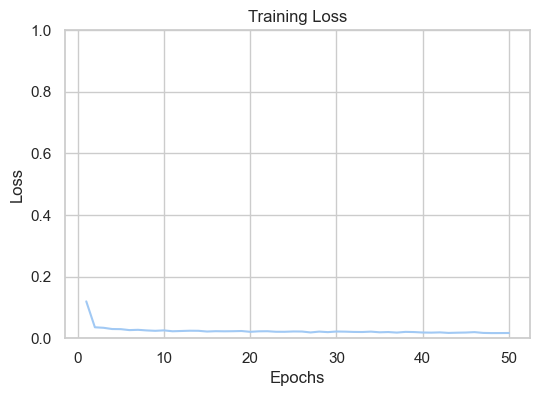

In [22]:
plot_metrics(model.train_loss, epochs=epochs, title='Loss')

Accuracy

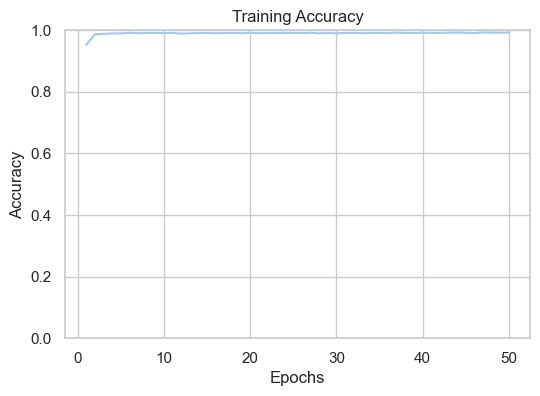

In [23]:
plot_metrics(model.train_accuracy, epochs=epochs, title='Accuracy')

F1 Macro which is the average F1 score across the epoch. This is a balance between Precision and Recall.

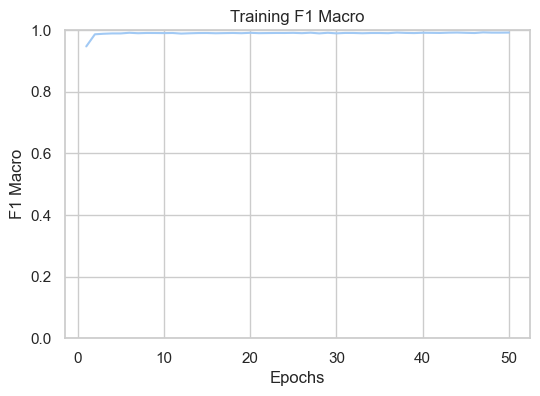

In [24]:
plot_metrics(model.train_f1, epochs=epochs, title='F1 Macro')

Epoch Time tells us on average how long each epoch took.

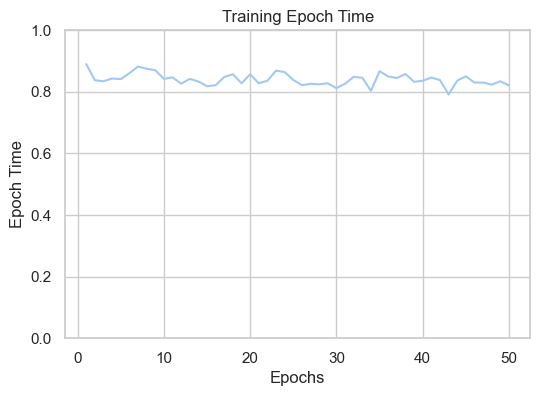

In [25]:
plot_metrics(model.epoch_time, epochs=epochs, title='Epoch Time')

We can select the epoch which we think the model converged at and reload it. Lets compare two epochs. The current one and one that looks like we reached the minmium earlier. First we need to run the Model on the test set and view the results in a confusion Matrix.

In [26]:
# Run model on test set.
model.test(test_loader)

Testing: 100%|██████████| 16/16 [00:00<00:00, 443.21batch/s]

Test Loss: 0.0378, Test Accuracy: 0.9890, Test F1: 0.9892


Straight away we see that the loss is not as low as the training set meaning we potentially overfitted the model. Lets check the results for each label.

In [27]:
# Check the docs for plot_confusion matrix.
help(plot_confusion_matrix)

Help on function plot_confusion_matrix in module Models.models:

plot_confusion_matrix(actual_labels, predicted_labels)
    Plot confusion matrix: Plot a confusion matrix using the results of the NNsmote class.

    Parameter:
    - actual_labels (tensor) The true labels of the data.
    - predicted_labels (tensor) The predicted labels from model.predicted_labels.



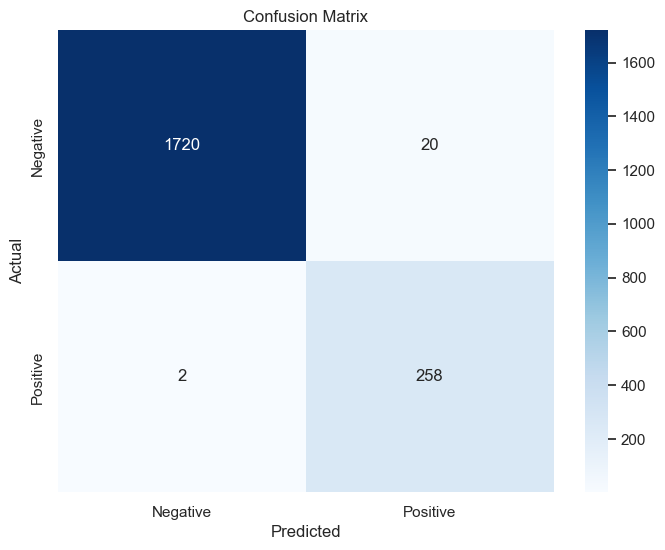

In [28]:
# So we put our actual labels and predicted labels in and get a result. Predicted labels are stored in the model.
plot_confusion_matrix(y_test, model.test_predicted)

As we can see the SMOTE sampling method focused on minority labels and only predicted 4 incorrectly but had some additional wrong predictions in the Normal labels. Lets reload a model from an earlier epoch and compare the result. Most of the time we want to take it from the 'knee' at the epoch which is when the model significantly reduces decreasing loss and optimise it from there. Lets take it from epoch 10 which is a bit after the knee.

In [29]:
# Find epoch 10 in the path and load it.
epoch = 10
model.load_model('./Models/saved_models/Test/PB_epoch_10.pth')

c:\Users\adi_s\Desktop\LSTM\Models\models.py:273: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Now run the model on test set and compare results.

In [30]:
# A decrease in loss.
model.test(test_loader)

Testing: 100%|██████████| 16/16 [00:00<00:00, 388.94batch/s]

Test Loss: 0.0297, Test Accuracy: 0.9875, Test F1: 0.9879


A better loss but worse accuracy. This means that our model has not fully converged at epoch 10 after all and was not overfitted at that point.

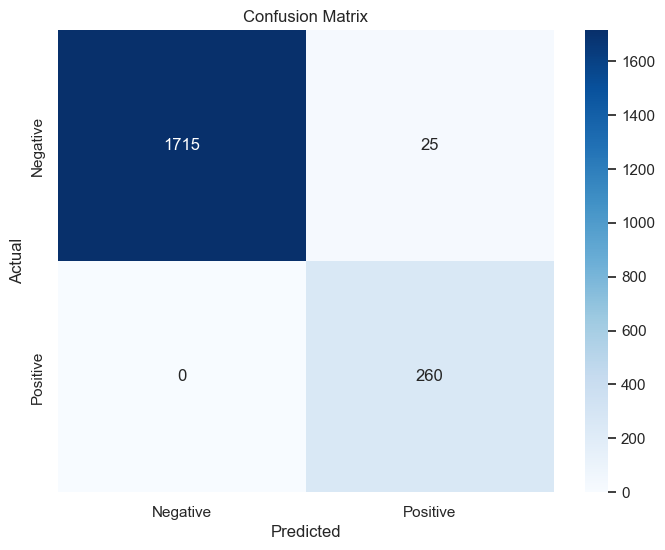

In [31]:
# Check accuracy.
plot_confusion_matrix(y_test, model.test_predicted)

Ok lets move forward into evaluating our correct predictions in threat labels through shap. First we need to compute the background using some sample data for both labels. Then we create another dataset of the correct predictions we want to evaluate and compute the shap values.

In [32]:
# Import shap.
import shap

In [33]:
# Create a background sample of the tensor.
idx = torch.randperm(X_test_tensor.size(0))[:1000]
background = X_test_tensor[idx]

In [34]:
# Create background.
xp = shap.DeepExplainer(model, background)

Now we need to add the labels back into our data so we can seperate correct predictions on threats then convert back into a tensor.

In [35]:
# Add the labels back in.
X_test['actual'] = y_test
X_test['predicted'] = model.test_predicted
# Then filter.
correct_threats = X_test[(X_test['actual'] == 1) & (X_test['predicted'] == 1)]

Lets check the length before we compute shap values. If it is greater than 1000, then you might want to resample it down to 1000.

In [36]:
print(len(correct_threats))

260


First we need to remove the actual and predicted labels and convert to a tensor. Then we compute shap values and additionally create our explainer object for cohorts and other values.

In [37]:
# Remove labels.
correct_threats = correct_threats.drop(columns=['actual', 'predicted'])
correct_threats = torch.tensor(correct_threats.to_numpy(), dtype=torch.float32)
# We drop them from X_test as we need these for the shap class.
X_test = X_test.drop(columns=['actual', 'predicted'])

In [38]:
# Compute shap values and explainer.
shap_values = xp.shap_values(correct_threats)
explainer = xp(correct_threats)

Now lets import the Shap class and plot some visuals (still in progress).

In [39]:
from Tools.shap_manager import SHAPmanager
# read docs (in progress)
help(SHAPmanager)

Help on class SHAPmanager in module Tools.shap_manager:

class SHAPmanager(SHAPbinary, SHAPmulti)
 |  SHAPmanager(shap_values, explainer, data, feature_names=None, label_type=None)
 |
 |  Method resolution order:
 |      SHAPmanager
 |      SHAPbinary
 |      SHAPmulti
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, shap_values, explainer, data, feature_names=None, label_type=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  ----------------------------------------------------------------------
 |  Methods inherited from SHAPbinary:
 |
 |  custom_group(self, type_of, category, limit=None, calculation=None)
 |      custom_group: Convert a group of categories based on top 30 for label encoded categories.
 |
 |      Parameters:
 |          - type_of (string) For 'label-encoded-specific' provide a list of values to encode and change the rest to 'Other'. For 'label-encoded' provide a limit and calculation to calculate top 30.
 |  

We set the manager to binary and it will inherit the SHAPbinary class.

In [40]:
sm = SHAPmanager(shap_values, explainer, correct_threats, X_test.columns, 'binary')

In [41]:
# Check inherited docs.
help(sm)

Help on SHAPmanager in module Tools.shap_manager object:

class SHAPmanager(SHAPbinary, SHAPmulti)
 |  SHAPmanager(shap_values, explainer, data, feature_names=None, label_type=None)
 |
 |  Method resolution order:
 |      SHAPmanager
 |      SHAPbinary
 |      SHAPmulti
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, shap_values, explainer, data, feature_names=None, label_type=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  ----------------------------------------------------------------------
 |  Methods inherited from SHAPbinary:
 |
 |  custom_group(self, type_of, category, limit=None, calculation=None)
 |      custom_group: Convert a group of categories based on top 30 for label encoded categories.
 |
 |      Parameters:
 |          - type_of (string) For 'label-encoded-specific' provide a list of values to encode and change the rest to 'Other'. For 'label-encoded' provide a limit and calculation to calculate top 30.
 | 

In [43]:
# Lets check the new docs.
# Its missing lots of information still..
help(sm)

Help on SHAPmanager in module Tools.shap_manager object:

class SHAPmanager(SHAPbinary, SHAPmulti)
 |  SHAPmanager(shap_values, explainer, data, feature_names=None, label_type=None)
 |
 |  Method resolution order:
 |      SHAPmanager
 |      SHAPbinary
 |      SHAPmulti
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, shap_values, explainer, data, feature_names=None, label_type=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  ----------------------------------------------------------------------
 |  Methods inherited from SHAPbinary:
 |
 |  custom_group(self, type_of, category, limit=None, calculation=None)
 |      custom_group: Convert a group of categories based on top 30 for label encoded categories.
 |
 |      Parameters:
 |          - type_of (string) For 'label-encoded-specific' provide a list of values to encode and change the rest to 'Other'. For 'label-encoded' provide a limit and calculation to calculate top 30.
 | 

Lets test some different plots and the stacked_group function.

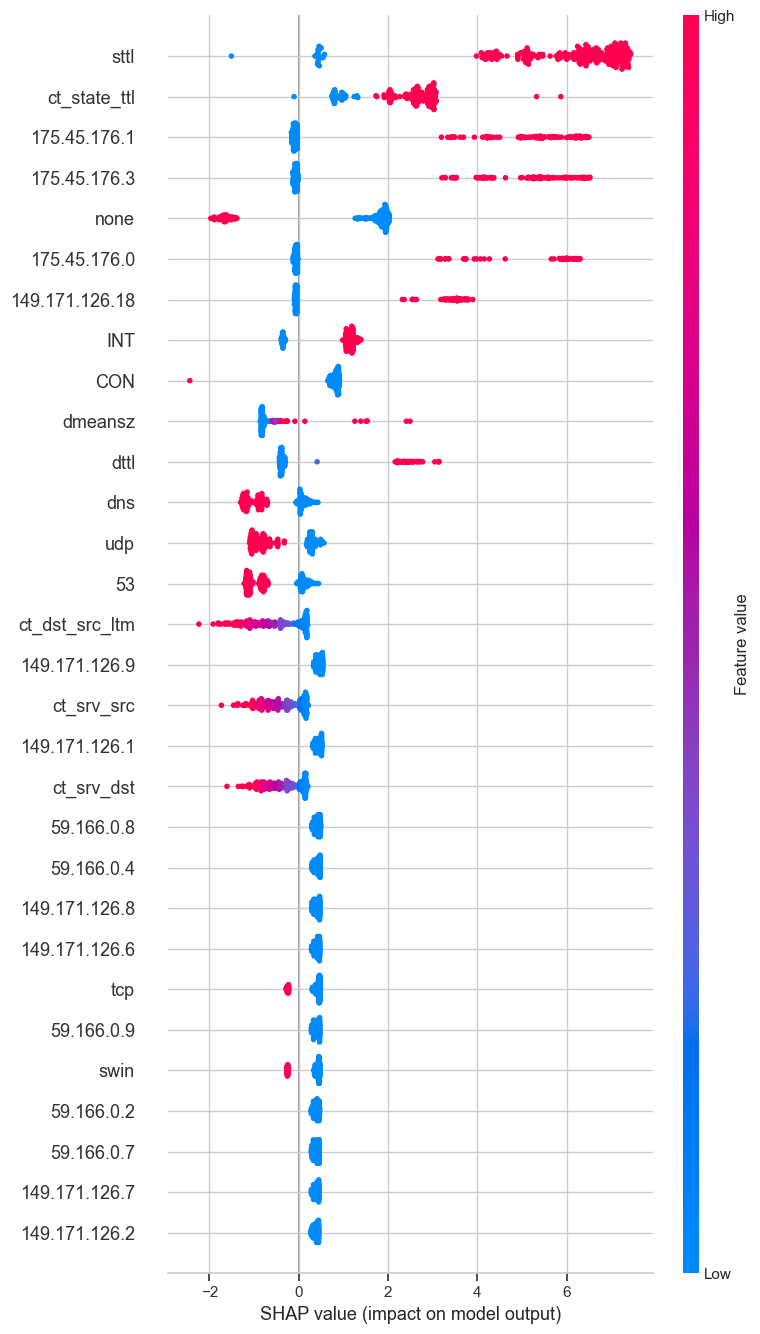

In [44]:
# Plot a summary plot.
type_of = 'summary'
max_features = 30
colour = None
sm.plot_summary(type_of, max_features, colour)

In [ ]:
# Plot cohorts. - Need to fix a few things I guess..
sm.plot_cohorts(2)

ValueError: Cohorts cannot be calculated on multiple outputs at once. Please make sure to specify the output index on which cohorts should be build, e.g. for a multi-class output shap_values[..., cohort_class].cohorts(2).

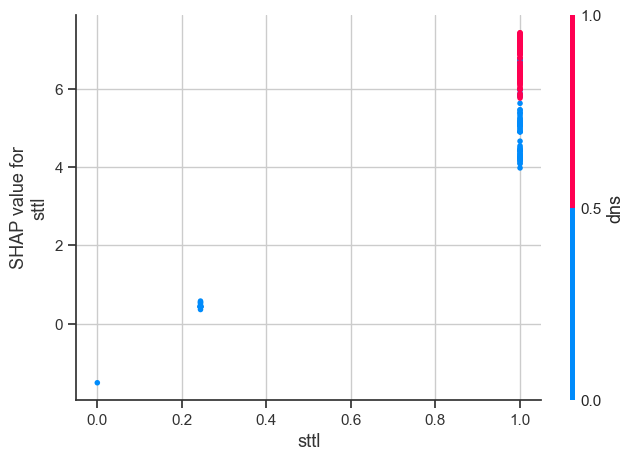

In [46]:
sm.plot_dependence('sttl', None)

Lets test the stack group function. Here we stack multiple one hot encoded variables for the dependency plot.

In [ ]:
# In progress... Need to find this error.
sm.stacked_group('service', 30, 'average')

ValueError: need at least one array to concatenate